first alg

Starting City (auto-chosen best): City_20
Number of cities visited: 50

Genetic Algorithm:
Distance: 602.5206414564963
Route: ['City_20', 'City_44', 'City_38', 'City_5', 'City_1', 'City_35', 'City_17', 'City_6', 'City_22', 'City_4', 'City_37', 'City_34', 'City_46', 'City_21', 'City_14', 'City_24', 'City_9', 'City_33', 'City_23', 'City_13', 'City_28', 'City_27', 'City_18', 'City_26', 'City_41', 'City_2', 'City_47', 'City_48', 'City_45', 'City_32', 'City_7', 'City_36', 'City_39', 'City_15', 'City_11', 'City_16', 'City_25', 'City_40', 'City_42', 'City_19', 'City_8', 'City_3', 'City_50', 'City_29', 'City_30', 'City_12', 'City_43', 'City_31', 'City_10', 'City_49', 'City_20']


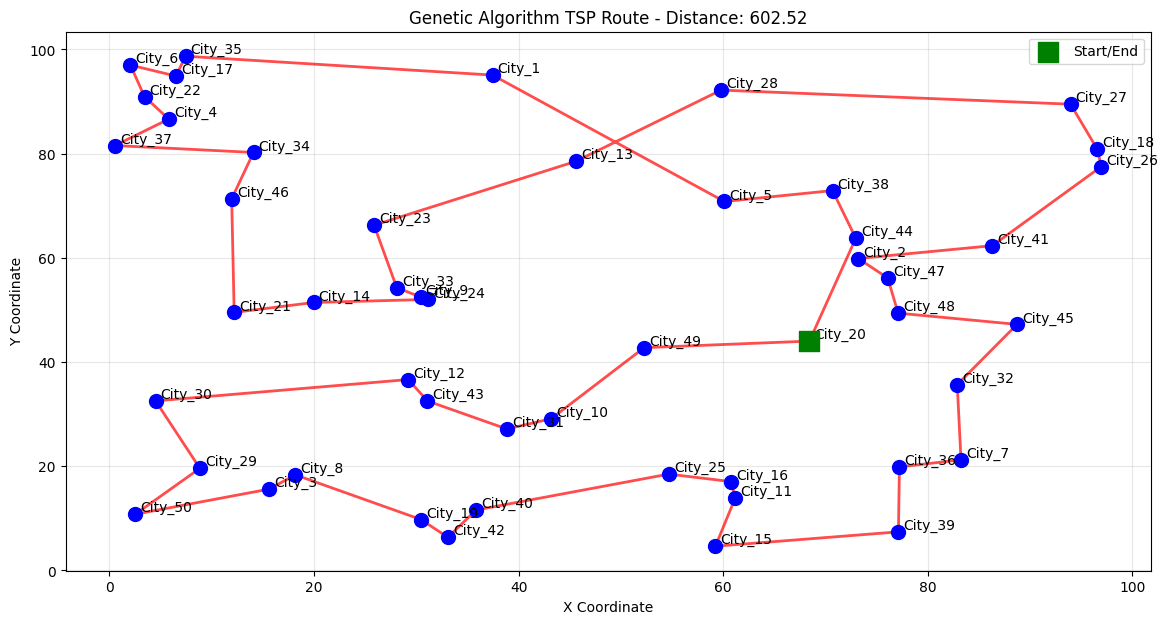

In [ ]:
import random
import math
import numpy as np

def calculate_distance(route):
    route_extended = np.append(route, [route[0]], axis=0)
    return np.sum(np.sqrt(np.sum(np.diff(route_extended, axis=0)**2, axis=1)))

def create_initial_population(pop_size, num_cities):
    population = []
    for _ in range(pop_size):
        route = list(range(num_cities))
        random.shuffle(route)
        population.append(route)
    return population

def calculate_fitness(route, cities):
    distance = calculate_distance(cities[route])
    return 1 / distance

def selection(population, cities, tournament_size=5):
    tournament = random.sample(population, tournament_size)
    return max(tournament, key=lambda route: calculate_fitness(route, cities))

def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [-1] * size
    child[start:end] = parent1[start:end]
    
    pointer = 0
    for city in parent2:
        if city not in child:
            while child[pointer] != -1:
                pointer += 1
            child[pointer] = city
    
    return child

def mutate(route, mutation_rate=0.01):
    for i in range(len(route)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(route) - 1)
            route[i], route[j] = route[j], route[i]
    return route

def create_nearest_neighbor_route(cities, start_index=0):
    n = len(cities)
    unvisited = set(range(n))
    route = [start_index]
    unvisited.remove(start_index)

    while unvisited:
        last = route[-1]
        next_city = min(
            unvisited,
            key=lambda j: np.linalg.norm(cities[last] - cities[j])
        )
        route.append(next_city)
        unvisited.remove(next_city)

    return route

def best_nearest_neighbor_route(cities):
    n = len(cities)
    best_distance = math.inf
    best_route = None
    best_start = None

    for start_index in range(n):
        route = create_nearest_neighbor_route(cities, start_index=start_index)
        distance = calculate_distance(cities[route])

        if distance < best_distance:
            best_distance = distance
            best_route = route
            best_start = start_index

    return best_start, best_route, best_distance

def genetic_algorithm(cities, pop_size=100, generations=1000, mutation_rate=0.01, start_index=None):
    num_cities = len(cities)
    
    if start_index is None:
        start_index, _, _ = best_nearest_neighbor_route(cities)
    
    population = create_initial_population(pop_size, num_cities)
    
    best_route = None
    best_distance = float('inf')
    
    for gen in range(generations):
        fitness_scores = [(route, calculate_fitness(route, cities)) for route in population]
        
        current_best = min(population, key=lambda route: calculate_distance(cities[route]))
        current_distance = calculate_distance(cities[current_best])
        
        if current_distance < best_distance:
            best_route = current_best.copy()
            best_distance = current_distance
        
        new_population = []
        
        new_population.append(best_route.copy())
        
        while len(new_population) < pop_size:
            parent1 = selection(population, cities)
            parent2 = selection(population, cities)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            new_population.append(child)
        
        population = new_population
    
    start_pos = best_route.index(start_index)
    best_route = best_route[start_pos:] + best_route[:start_pos]
    
    return best_route, best_distance, start_index


pop_size = 200
generations = 2000
mutation_rate = 0.02
random.seed(42)


start_city_idx = 0
end_city_idx = 49
num_cities_to_visit = 50

city_indices = list(range(start_city_idx, end_city_idx + 1))

if len(city_indices) > num_cities_to_visit:
    middle_cities = city_indices[1:-1]
    random.shuffle(middle_cities)
    selected_middle = middle_cities[:num_cities_to_visit - 2]
    city_indices = [city_indices[0]] + selected_middle + [city_indices[-1]]
else:
    city_indices = city_indices[:num_cities_to_visit]

subset_data = full_data.iloc[city_indices].reset_index(drop=True)
cities = subset_data[["X", "Y"]].values

ga_route, ga_distance, chosen_start_index = genetic_algorithm(
    cities, pop_size=pop_size, generations=generations, mutation_rate=mutation_rate, start_index=None
)

original_route = [city_indices[i] for i in ga_route]

start_city = subset_data.iloc[ga_route[0]]['City']
print(f"Starting City (auto-chosen best): {start_city}")
print(f"Number of cities visited: {len(ga_route)}")

print("\nGenetic Algorithm:")
print("Distance:", ga_distance)
print("Route:", [subset_data.iloc[i]['City'] for i in ga_route] + [subset_data.iloc[ga_route[0]]['City']])

plt.figure(figsize=(14, 7))

plt.scatter(subset_data["X"], subset_data["Y"], s=100, c='blue', zorder=3)

for i, row in subset_data.iterrows():
    plt.text(row["X"] + 0.5, row["Y"] + 0.5, row["City"], fontsize=10)

route_coords = cities[ga_route]
route_coords = np.append(route_coords, [route_coords[0]], axis=0)
plt.plot(route_coords[:, 0], route_coords[:, 1], 'r-', linewidth=2, alpha=0.7, zorder=2)

start_coords = cities[ga_route[0]]
plt.scatter(start_coords[0], start_coords[1], s=200, c='green', marker='s', zorder=4, label='Start/End')

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title(f"Genetic Algorithm TSP Route - Distance: {ga_distance:.2f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()